In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
patients = pd.read_csv('../data/raw/patients.csv')
encounters = pd.read_csv('../data/raw/encounters.csv')
conditions = pd.read_csv('../data/raw/conditions.csv')

In [3]:
# CREATE READMISSION DATA (calculated in the first notebook)
def calculate_readmission_data(encounters_df):
    inpatient_encounters = encounters_df[encounters_df['ENCOUNTERCLASS'] == 'inpatient'].copy()
    inpatient_encounters['START'] = pd.to_datetime(inpatient_encounters['START'])
    inpatient_encounters['STOP'] = pd.to_datetime(inpatient_encounters['STOP'])
    inpatient_encounters['length_of_stay'] = (inpatient_encounters['STOP'] - inpatient_encounters['START']).dt.days
    readmission_data = inpatient_encounters[inpatient_encounters['length_of_stay'] <= 30].copy()
    
    readmission_data = readmission_data.sort_values(['PATIENT', 'START'])
    readmission_data['next_admission_date'] = readmission_data.groupby('PATIENT')['START'].shift(-1)
    readmission_data['days_to_readmit'] = (readmission_data['next_admission_date'] - readmission_data['STOP']).dt.days
    readmission_data['readmission_30_days'] = (readmission_data['days_to_readmit'] <= 30) & (readmission_data['days_to_readmit'] >= 0)
    
    return readmission_data

In [5]:
# Generate readmission data
readmission_data = calculate_readmission_data(encounters)
print(f"Readmission data ready: {len(readmission_data)} admissions")
print(f"Readmission rate: {readmission_data['readmission_30_days'].mean()*100:.2f}%")

Readmission data ready: 1724 admissions
Readmission rate: 30.97%


In [9]:
# merge with patients demographic data 
# merge readmission data with patients data
readmission_with_demo = readmission_data.merge(
    patients[['Id','GENDER','RACE','ETHNICITY','BIRTHDATE','MARITAL']],
    left_on = 'PATIENT',
    right_on = 'Id',
    how = 'left'
)
# calculate age at admission
readmission_with_demo['START'] = pd.to_datetime(readmission_with_demo['START']).dt.tz_localize(None)
readmission_with_demo['BIRTHDATE'] = pd.to_datetime(readmission_with_demo['BIRTHDATE']).dt.tz_localize(None)
readmission_with_demo['age_at_admission'] = (
    readmission_with_demo['START'] - readmission_with_demo['BIRTHDATE']
).dt.days // 365
print(f"Merged data: {len(readmission_with_demo)} records")
print("First 3 records:")
display(readmission_with_demo[['PATIENT', 'GENDER', 'RACE', 'age_at_admission', 'readmission_30_days']].head(3))

Merged data: 1724 records
First 3 records:


,PATIENT,GENDER,RACE,age_at_admission,readmission_30_days
0,00ae3b00-9500-efc1-2758-a93d3f77e650,F,black,63,False
1,02257002-550c-6de2-2bc0-0bb2bb497e84,M,white,72,False
2,02ceca12-357f-981e-dcf3-3d26d3c1ff82,F,white,51,False


In [10]:
# readmission analysis by age group
# we are looking for an answer to Are elderly patients at higher risk?

# Create age groups
readmission_with_demo['age_group'] = pd.cut(
    readmission_with_demo['age_at_admission'],
    bins=[0, 18, 35, 50, 65, 100],
    labels=['0-18', '19-35', '36-50', '51-65', '65+']
)

# Calculate readmission rates by age group
age_analysis = readmission_with_demo.groupby('age_group').agg({
    'readmission_30_days': ['count', 'mean', 'sum']
}).round(4)

# Rename columns
age_analysis.columns = ['total_admissions', 'readmission_rate', 'readmission_count']
age_analysis['readmission_rate_%'] = (age_analysis['readmission_rate'] * 100).round(2)

print(age_analysis[['total_admissions', 'readmission_count', 'readmission_rate_%']])

           total_admissions  readmission_count  readmission_rate_%
age_group                                                         
0-18                    111                  0                0.00
19-35                   174                  2                1.15
36-50                   255                 90               35.29
51-65                   709                327               46.12
65+                     472                115               24.36


C:\Users\DELL\AppData\Local\Temp\ipykernel_11060\2560944712.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_analysis = readmission_with_demo.groupby('age_group').agg({


In [11]:
# readmission analysis by gender 

# group by gender and calculate readmission rates
gender_analysis = readmission_with_demo.groupby('GENDER').agg({
    'readmission_30_days': ['count', 'mean', 'sum']
}).round(4)

# Rename columns
gender_analysis.columns = ['total_admissions', 'readmission_rate', 'readmission_count']
gender_analysis['readmission_rate_%'] = (gender_analysis['readmission_rate'] * 100).round(2)

print(gender_analysis[['total_admissions', 'readmission_count', 'readmission_rate_%']])

        total_admissions  readmission_count  readmission_rate_%
GENDER                                                         
F                    996                295               29.62
M                    728                239               32.83


In [13]:
# readmission analysis by rate 

race_analysis = readmission_with_demo.groupby('RACE').agg({
    'readmission_30_days':['count','mean','sum']
}).round(4)

# rename coloumns
race_analysis.columns = ['total_admissions', 'readmission_rate', 'readmission_count']
race_analysis['readmission_rate_%'] = (race_analysis['readmission_rate'] * 100).round(2)
print(race_analysis[['total_admissions', 'readmission_count', 'readmission_rate_%']].sort_values('readmission_rate_%', ascending=False))

          total_admissions  readmission_count  readmission_rate_%
RACE                                                             
black                  247                104               42.11
white                 1394                430               30.85
asian                   78                  0                0.00
hawaiian                 3                  0                0.00
other                    2                  0                0.00


In [16]:
# chronic disease analysis
top_conditions = conditions['DESCRIPTION'].value_counts().head(30)
print(top_conditions)

DESCRIPTION
Full-time employment (finding)                               13805
Stress (finding)                                              5137
Part-time employment (finding)                                2426
Social isolation (finding)                                    1243
Viral sinusitis (disorder)                                    1233
Limited social contact (finding)                              1200
Not in labor force (finding)                                  1077
Victim of intimate partner abuse (finding)                     819
Acute viral pharyngitis (disorder)                             678
Acute bronchitis (disorder)                                    571
Reports of violence in the environment (finding)               565
Normal pregnancy                                               527
Received higher education (finding)                            523
Body mass index 30+ - obesity (finding)                        463
Risk activity involvement (finding)               

In [20]:
# Filter conditions where DESCRIPTION contains "disorder"
disorder_conditions = conditions[conditions['DESCRIPTION'].str.contains('disorder', case=False, na=False)]

# Show top 20 most frequent disorder diseases
top_disorders = disorder_conditions['DESCRIPTION'].value_counts().head(20)
print(top_disorders)

DESCRIPTION
Viral sinusitis (disorder)                     1233
Acute viral pharyngitis (disorder)              678
Acute bronchitis (disorder)                     571
Anemia (disorder)                               324
Chronic sinusitis (disorder)                    219
Streptococcal sore throat (disorder)            162
Acute bacterial sinusitis (disorder)             74
Hypertriglyceridemia (disorder)                  71
Metabolic syndrome X (disorder)                  68
Osteoporosis (disorder)                          58
Sinusitis (disorder)                             54
Seizure disorder                                 47
Hyperglycemia (disorder)                         41
Sepsis (disorder)                                40
Chronic congestive heart failure (disorder)      40
Alzheimer's disease (disorder)                   37
Diabetic renal disease (disorder)                31
Chronic kidney disease stage 1 (disorder)        30
Carcinoma in situ of prostate (disorder)         28


In [21]:
# Select only chronic disorders from the top 20 (eliminate acute)

chronic_disorders_updated = [
    'Anemia (disorder)',
    'Chronic sinusitis (disorder)', 
    'Hypertriglyceridemia (disorder)',
    'Metabolic syndrome X (disorder)',
    'Osteoporosis (disorder)',
    'Seizure disorder',
    'Hyperglycemia (disorder)',
    'Chronic congestive heart failure (disorder)',
    "Alzheimer's disease (disorder)",
    'Diabetic renal disease (disorder)',
    'Chronic kidney disease stage 1 (disorder)',
    'Fibromyalgia (disorder)'
]

# Filter only these chronic disorders
chronic_conditions_updated = conditions[conditions['DESCRIPTION'].isin(chronic_disorders_updated)]

print(f"Number of chronic disease records: {len(chronic_conditions_updated)}")
print(f"Number of patients with chronic disease: {chronic_conditions_updated['PATIENT'].nunique()}")

# Count chronic diseases per patient
patient_chronic_counts_updated = chronic_conditions_updated.groupby('PATIENT')['DESCRIPTION'].nunique()

# Add to readmission data
readmission_with_demo['chronic_disease_count_updated'] = readmission_with_demo['PATIENT'].map(patient_chronic_counts_updated).fillna(0)

# Calculate readmission rates by chronic disease count
chronic_analysis_updated = readmission_with_demo.groupby('chronic_disease_count_updated').agg({
    'readmission_30_days': ['count', 'mean', 'sum']
}).round(4)

chronic_analysis_updated.columns = ['total_admissions', 'readmission_rate', 'readmission_count']
chronic_analysis_updated['readmission_rate_%'] = (chronic_analysis_updated['readmission_rate'] * 100).round(2)

print("\n READMISSION BY REAL CHRONIC DISEASE COUNT:")
print(chronic_analysis_updated[['total_admissions', 'readmission_count', 'readmission_rate_%']])

Number of chronic disease records: 992
Number of patients with chronic disease: 561

 READMISSION BY REAL CHRONIC DISEASE COUNT:
                               total_admissions  readmission_count  \
chronic_disease_count_updated                                        
0.0                                         367                 87   
1.0                                         797                235   
2.0                                         168                 64   
3.0                                         184                 92   
4.0                                          34                  0   
5.0                                          87                 33   
6.0                                          86                 23   
7.0                                           1                  0   

                               readmission_rate_%  
chronic_disease_count_updated                      
0.0                                         23.71  
1.0           

In [22]:
# readmission risk analysis by individual chronic diseases

for disease in chronic_disorders_updated:
    # Find patients with this disease
    patients_with_disease = chronic_conditions_updated[
        chronic_conditions_updated['DESCRIPTION'] == disease
    ]['PATIENT'].unique()
    
    # Calculate readmission rate
    if len(patients_with_disease) > 0:
        disease_data = readmission_with_demo[
            readmission_with_demo['PATIENT'].isin(patients_with_disease)
        ]
        
        if len(disease_data) > 0:
            disease_readmission_rate = disease_data['readmission_30_days'].mean()
            patient_count = len(disease_data)
            
            print(f"• {disease.split('(')[0].strip()}: {patient_count} patients, Readmission: {disease_readmission_rate*100:.2f}%")

• Anemia: 968 patients, Readmission: 39.05%
• Chronic sinusitis: 255 patients, Readmission: 21.57%
• Hypertriglyceridemia: 265 patients, Readmission: 40.38%
• Metabolic syndrome X: 263 patients, Readmission: 40.68%
• Osteoporosis: 87 patients, Readmission: 12.64%
• Seizure disorder: 133 patients, Readmission: 42.11%
• Hyperglycemia: 98 patients, Readmission: 22.45%
• Chronic congestive heart failure: 218 patients, Readmission: 40.83%
• Alzheimer's disease: 89 patients, Readmission: 0.00%
• Diabetic renal disease: 189 patients, Readmission: 29.63%
• Chronic kidney disease stage 1: 172 patients, Readmission: 32.56%
• Fibromyalgia: 42 patients, Readmission: 11.90%


C:\Users\DELL\AppData\Local\Temp\ipykernel_11060\4072661746.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_plot = readmission_with_demo.groupby('age_group')['readmission_30_days'].mean() * 100


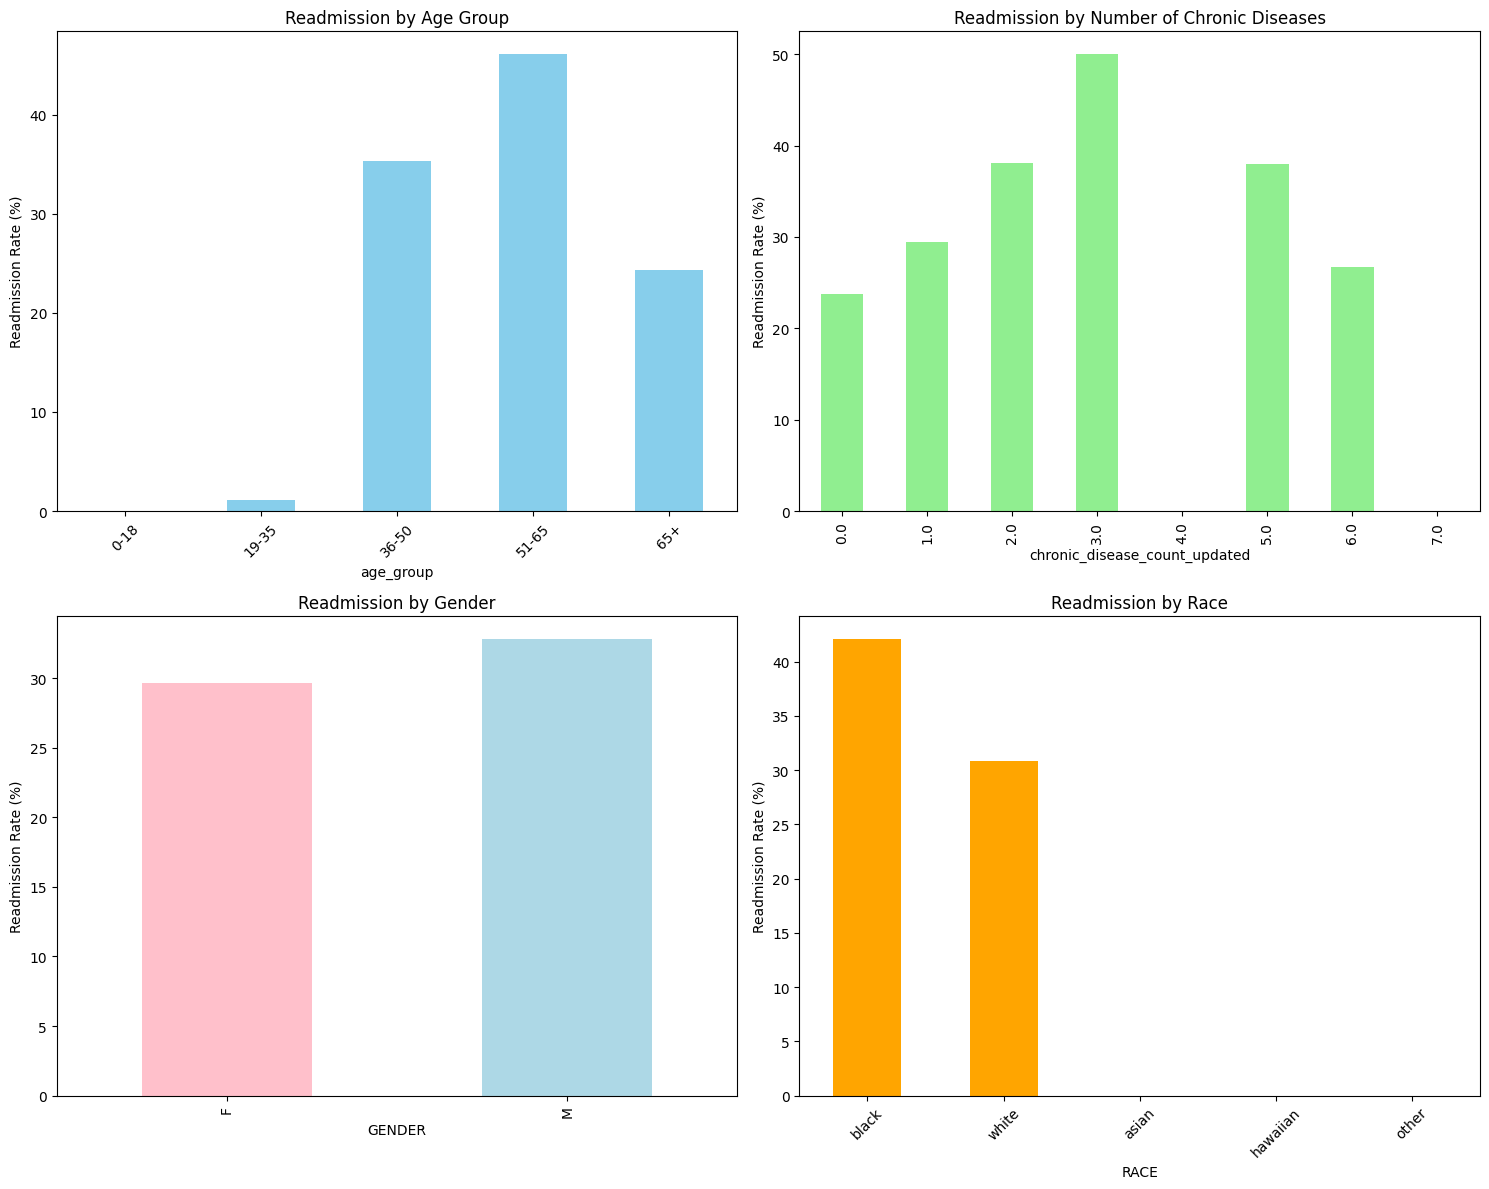

In [36]:
# visualizing the risk factors for readmission

plt.figure(figsize=(15, 12))

#readmission by age group
plt.subplot(2, 2, 1)
age_plot = readmission_with_demo.groupby('age_group')['readmission_30_days'].mean() * 100
age_plot.plot(kind='bar', color='skyblue')
plt.title('Readmission by Age Group')
plt.ylabel('Readmission Rate (%)')
plt.xticks(rotation=45)

# Readmission by Number of Chronic Diseases
plt.subplot(2, 2, 2)
chronic_plot = readmission_with_demo.groupby('chronic_disease_count_updated')['readmission_30_days'].mean() * 100
chronic_plot.plot(kind='bar', color='lightgreen')
plt.title('Readmission by Number of Chronic Diseases')
plt.ylabel('Readmission Rate (%)')

# Readmission by Gender
plt.subplot(2, 2, 3)
gender_plot = readmission_with_demo.groupby('GENDER')['readmission_30_days'].mean() * 100
gender_plot.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Readmission by Gender')
plt.ylabel('Readmission Rate (%)')

# Readmission by Race
plt.subplot(2, 2, 4)
race_plot = readmission_with_demo.groupby('RACE')['readmission_30_days'].mean() * 100
race_plot = race_plot.sort_values(ascending=False)
race_plot.plot(kind='bar', color='orange')
plt.title('Readmission by Race')
plt.ylabel('Readmission Rate (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()